# RECOMMENDING BOOKS TO USERS OF BOOKCROSSINGS.COM

BookCrossing.com is a site where users can share and rate thousands of books.  In 2001, they released some of their user data.  This project aims to create a recommendation system for the BookCrossing users, by using over 100,000 ratings on a scale of 1 (low) to 10 (high).

In [1]:
#Import all necessary libraries
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import cython
%matplotlib inline


First, we'll bring in all 3 datasets provided by BookCrossings, User Data, Book Data and Ratings Data
# User Dataset EDA
User data contains geographical location (user entered data) and age.

In [2]:
#Import data
Users = pd.read_csv('./BX-CSV-Dump/BX-Users.csv', sep=";")
print Users.head()
print Users.dtypes
print (Users.isnull().sum())

   User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN
User-ID       int64
Location     object
Age         float64
dtype: object
User-ID          0
Location         0
Age         110762
dtype: int64


In [3]:
#Change Column names
#Users.columns=['User_ID', 'Location', 'Age']
#Users['City'], Users['State'], Users['Country'] =
Users['Loc_upper']  = Users['Location'].str.upper()
Users['City']  = Users['Loc_upper'].str.split(", ").str.get(0)
Users['State']  = Users['Loc_upper'].str.split(", ").str.get(1)
Users['Country']  = Users['Loc_upper'].str.split(", ").str.get(2)

Users['OtherLoc']  = Users['Loc_upper'].str.split(", ").str.get(3)
#print Users['OtherLoc'].value_counts()

Users.head()

,User-ID,Location,Age,Loc_upper,City,State,Country,OtherLoc
0,1,"nyc, new york, usa",NaN,"NYC, NEW YORK, USA",NYC,NEW YORK,USA,NaN
1,2,"stockton, california, usa",18.0,"STOCKTON, CALIFORNIA, USA",STOCKTON,CALIFORNIA,USA,NaN
2,3,"moscow, yukon territory, russia",NaN,"MOSCOW, YUKON TERRITORY, RUSSIA",MOSCOW,YUKON TERRITORY,RUSSIA,NaN
3,4,"porto, v.n.gaia, portugal",17.0,"PORTO, V.N.GAIA, PORTUGAL",PORTO,V.N.GAIA,PORTUGAL,NaN
4,5,"farnborough, hants, united kingdom",NaN,"FARNBOROUGH, HANTS, UNITED KINGDOM",FARNBOROUGH,HANTS,UNITED KINGDOM,NaN


In [4]:
#Look for missing values in new columns
print (Users.isnull().sum())
Users['Country'].value_counts().head()

User-ID           0
Location          0
Age          110762
Loc_upper         0
City              0
State             1
Country        4577
OtherLoc     277834
dtype: int64


USA               139425
CANADA             21603
UNITED KINGDOM     18314
GERMANY            17025
SPAIN              13103
Name: Country, dtype: int64

In [5]:
#For observations where country is missing, find the most likely country based on the city and/or state provided 
country_by_city = Users.groupby(Users['City'])['Country'].apply(lambda x: x.value_counts()[:1])
country_by_city.head(20)
def get_country(in_city, country):
    if country.empty:
        return country_by_city.loc["PARIS"]
    else:
        return country

#Users['Country_Fill']= Users.apply(lambda x: get_country(Users['City'], Users['Country']), axis=1)


In [6]:
country_by_city.head()
print country_by_city.loc["PARIS"]

FRANCE    1097
Name: Country, dtype: int64


In [7]:
Users.head()
Users['City'].value_counts()
Users['State'].value_counts().head()

CALIFORNIA    19839
N/A           12421
ENGLAND       10656
ONTARIO        8717
TEXAS          8376
Name: State, dtype: int64

In [8]:
#See Unique values of location
Users.groupby(['City','State', 'Country']).size().reset_index().rename(columns={0:'count'}).head()


,City,State,Country,count
0,,,ALGERIA,1
1,,,AUSTRALIA,1
2,,,BELIZE,1
3,,,CANADA,1
4,,,GERMANY,3


count    278858.000000
mean         33.592581
std          10.711113
min           1.000000
25%          29.000000
50%          32.000000
75%          35.000000
max         100.000000
Name: Age_Clean, dtype: float64
User-ID           0
Location          0
Age          110762
Loc_upper         0
City              0
State             1
Country        4577
OtherLoc     277834
Age_Clean         0
dtype: int64


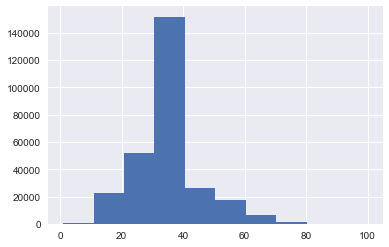

In [9]:
#Define Function to clean age data - ensure that ages provided are between 0 and 100 
def age_clean(Age):
    if Age < 1:
        return np.NaN
    elif Age >= 1 and Age <=100:
        return Age
    else:
        return np.NaN    

#Apply function to Age
Users['Age_Clean'] = Users['Age'].apply(age_clean)

#Because many of the users' Age is listed as NaN, replace NaN with median age of the dataset
replace_age = Users['Age_Clean'].median()
Users['Age_Clean'].fillna(replace_age, inplace=True)
print Users['Age_Clean'].describe()

#View distribution of clean data
Users['Age_Clean'].hist()
print (Users.isnull().sum())

# Book Data EDA
Book Data contains relevent information about each unique book such as title, author, year of publication and publisher. Books are unique by ISBN. URLs with links to cover images are included in the dataset but ignored for this project.

In [10]:
import csv
book_list=[]
with open('./BX-CSV-Dump/BX-Books.csv', 'rb') as csvfile:
    book = csv.reader(csvfile, delimiter=";")
    for row in book:
        book_list.append(row)

Books = pd.DataFrame(book_list[1:],columns=['ISBN', 'Title','Author','Pub_Year', 'Publisher', 'URL1', 'URL2', 'URL3', 'EXTRA1', 'EXTRA2', 'EXTRA3'])
Books.head()

,ISBN,Title,Author,Pub_Year,Publisher,URL1,URL2,URL3,EXTRA1,EXTRA2,EXTRA3
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,None,None,None
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,None,None,None
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,None,None,None
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,None,None,None
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,None,None,None


In [11]:
#Delete columns that will not be used
del Books['URL1']
del Books['URL2']
del Books['URL3']
del Books['EXTRA1']
del Books['EXTRA2']
del Books['EXTRA3']
Books['Title']= Books['Title'].str.upper()
Books['Author']= Books['Author'].str.upper()
Books.head()
#Books.shape()

,ISBN,Title,Author,Pub_Year,Publisher
0,0195153448,CLASSICAL MYTHOLOGY,MARK P. O. MORFORD,2002,Oxford University Press
1,0002005018,CLARA CALLAN,RICHARD BRUCE WRIGHT,2001,HarperFlamingo Canada
2,0060973129,DECISION IN NORMANDY,CARLO D'ESTE,1991,HarperPerennial
3,0374157065,FLU: THE STORY OF THE GREAT INFLUENZA PANDEMIC...,GINA BARI KOLATA,1999,Farrar Straus Giroux
4,0393045218,THE MUMMIES OF URUMCHI,E. J. W. BARBER,1999,W. W. Norton &amp; Company


In [12]:
#Check for missing values within the Book Dataset
print (Books.isnull().sum())

ISBN         0
Title        0
Author       0
Pub_Year     0
Publisher    0
dtype: int64


In [13]:
Books.dtypes

ISBN         object
Title        object
Author       object
Pub_Year     object
Publisher    object
dtype: object

In [14]:
#Duplicate Books - same Title/Author, different publication/isbn
Title_Auth = Books.groupby(['Title','Author']).size().reset_index().rename(columns={0:'count'})
Title_Auth[Title_Auth['count']>1].sort_values(by='count', ascending=False).head()

#Books[Books['Title_U']=='WUTHERING HEIGHTS']

,Title,Author,count
112450,LITTLE WOMEN,LOUISA MAY ALCOTT,23
245883,WUTHERING HEIGHTS,EMILY BRONTE,22
9499,ADVENTURES OF HUCKLEBERRY FINN,MARK TWAIN,20
147725,PRIDE AND PREJUDICE,JANE AUSTEN,19
213754,THE SECRET GARDEN,FRANCES HODGSON BURNETT,17


# Rating Data EDA
The Ratings data contains both user-given ratings (on a scale of 1 to 10) as well as implicit ratings (rating = 0)

In [15]:
#Bring in Ratings Dataset
Ratings = pd.read_csv('./BX-CSV-Dump/BX-Book-Ratings.csv', sep=";")

In [16]:
#What does Ratings Data look like?
print Ratings.head()
print Ratings.dtypes
print (Ratings.isnull().sum())

   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6
User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [17]:
#What does the rating distribution look like?
Ratings['Book-Rating'].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: Book-Rating, dtype: int64

   User-ID        ISBN  Book-Rating  Implicit_Flag
0   276725  034545104X            0              1
1   276726  0155061224            5              0
2   276727  0446520802            0              1
3   276729  052165615X            3              0
4   276729  0521795028            6              0
716109


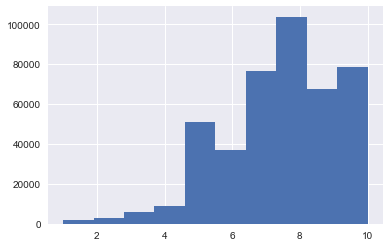

In [18]:
#Create Implicit  dummy variable
Ratings['Implicit_Flag'] = np.where(Ratings['Book-Rating'] == 0, 1, 0)
print Ratings.head()

#Ratings 1 - 10 Distribution
Ratings['Book-Rating'][Ratings['Implicit_Flag'] == 0].hist()

#Implicit Rating Counts
print Ratings['Book-Rating'][Ratings['Implicit_Flag'] == 1].count()

In [19]:
#Most Frequently Rated Books
Ratings['ISBN'].value_counts().head(10)

0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
044023722X     647
0679781587     639
0142001740     615
067976402X     614
0671027360     586
Name: ISBN, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f954f90>]], dtype=object)

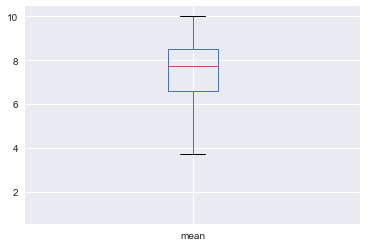

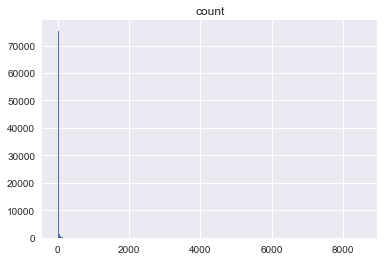

In [20]:
#Ratings per User and Average Rating Per User
RatingsPerUser = Ratings['Book-Rating'][Ratings['Implicit_Flag']==0].groupby(Ratings['User-ID']).agg(['mean',  'count'])
RatingsPerUser.sort_values(by=['count','mean'], ascending=False)
RatingsPerUser.boxplot(['mean'])
RatingsPerUser.hist(['count'], bins =300)



In [21]:
#Find mean rating of each book
CumRating = Ratings['Book-Rating'][Ratings['Implicit_Flag']==0].groupby(Ratings['ISBN']).agg(['mean',  'count'])
CumRating.sort_values(by=['count','mean'], ascending=False).head(10)

,mean,count
ISBN,,
0316666343,8.185290,707
0971880107,4.390706,581
0385504209,8.435318,487
0312195516,8.182768,383
0679781587,8.408408,333
0060928336,7.887500,320
059035342X,8.939297,313
0142001740,8.452769,307
0446672211,8.142373,295


As the final piece of data preparation, merge the Book and Ratings datasets for model training and evaluation.

In [22]:
#Merge the Ratings and Book Datasets so that we have one dataset that will go into the model.  
BookRatings = pd.merge(Ratings, Books)
print BookRatings.tail()

#For the Model build, we are only going to look at user-given ratings - no implicit ratings
BookRatings = BookRatings[BookRatings['Implicit_Flag']==0]
BookRatings.shape


         User-ID        ISBN  Book-Rating  Implicit_Flag  \
1031170   276688  0517145553            0              1   
1031171   276688  1575660792            7              0   
1031172   276690  0590907301            0              1   
1031173   276704  0679752714            0              1   
1031174   276704  0806917695            5              0   

                                                     Title           Author  \
1031170                                    MOSTLY HARMLESS    DOUGLAS ADAMS   
1031171                                        GRAY MATTER  SHIRLEY KENNETT   
1031172  TRIPLET TROUBLE AND THE CLASS TRIP (TRIPLET TR...     DEBBIE DADEY   
1031173  A DESERT OF PURE FEELING (VINTAGE CONTEMPORARIES)   JUDITH FREEMAN   
1031174  PERPLEXING LATERAL THINKING PUZZLES: SCHOLASTI...      PAUL SLOANE   

        Pub_Year                          Publisher  
1031170     1995             Random House Value Pub  
1031171     1996  Kensington Publishing Corporation  
10

(383852, 8)

# Model Build
To build recommender system, we will use the Surprise package
http://surprise.readthedocs.io/

Steps Taken:
1. Import package (FYI package makes use of .pyx files which require a C compiler installed on your computer
2. Randomly Sample dataset (due to memory constraint)
3. Read the data into the package (can use pandas dataframe)
4. Create a holdout test group and data folds for cross validation(prevents knowledge leakage)
5. Determine the baseline performance by calculating RMSE if we just predicted the global average book rating for every user/book pair
6. Select model type and test out different values of k
7. Train model with decided value of k and similarity function. Observe RMSE of cross validation results.
8. Make predictions and evaluate the performance - using RMSE


In [52]:
#Full Dataset requires more processing power than is available, 
#Solution : Take random sample of the final dataset to train/test the model
BR_Sample = BookRatings.sample(frac = .35, replace = False, random_state=42)
print BR_Sample.shape

#from surprise import SVD
from surprise import Dataset
from surprise import evaluate, print_perf
from surprise import Reader
from surprise import accuracy
from surprise import KNNWithMeans
from surprise import KNNBaseline


#Define Reader with appropriate Rating Scale
reader = Reader(rating_scale=(1, 10))

# Load the BookRatings dataset
data = Dataset.load_from_df(BR_Sample[['User-ID', 'ISBN', 'Book-Rating']], reader)
raw_ratings = data.raw_ratings

(134348, 8)


In [53]:
#Randomly sort data so that we can slice out Train/Test sets
np.random.seed(42)
np.random.shuffle(raw_ratings)

#Create distinct datasets for Train/Test - 90/10 split
train_set_pct = .9
threshold = int(train_set_pct * len(raw_ratings))
train_data = raw_ratings[:threshold]
test_data = raw_ratings[threshold:]

#Assign the train_data to be 'raw_ratings' (what the package will model)
#We will later reassign the test_data to 'raw_ratings' to get predictions on unseen data
data.raw_ratings = train_data
trainset = data.build_full_trainset()

#Split Training Data into folds for cross-validation.
data.split(n_folds=3)



In [54]:
#Find Baseline - If we predicted the average rating for every user-item combo, what would be RMSE?
mean_rating = trainset.global_mean
print "Average Rating Given (Trainset): ", mean_rating

df = pd.DataFrame(data.raw_ratings, columns=['uid', 'iid', 'r_ui', 'Null'])
df['avg'] = mean_rating
rmse = ((df.r_ui - df.avg) ** 2).mean() ** .5
print 'RMSE (predict average rating):', rmse

Average Rating Given (Trainset):  7.62764136197
RMSE (predict average rating): 1.84422753495


In [55]:
#Training the Model

#Choose the type of algorithm to be used
sim_options = {'name': 'cosine', 'user_based': False}
algo = KNNBaseline(k=100, sim_options=sim_options)

#Use the 3 folds to create train/test sets, training and testing the model to get an average
for trainset, testset in data.folds():
    algo.train(trainset)
    algo.test(testset)
    
#trainset = data.build_full_trainset()
#algo.train(trainset)


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
#Training the Model - Finding K

#Choose the type of algorithm to be used
sim_options = {'name': 'cosine', 'user_based': False}

k=[40, 100, 300, 500]
for i in k:
    algo = KNNBaseline(k=i, sim_options=sim_options)

    algo.train(trainset)

    testset = data.construct_testset(test_data)  
    predictions = algo.test(testset)
    print 'k= ' , i
    print 'Unbiased Accuracy: ', accuracy.rmse(predictions)

In [56]:
# Evaluate performances of our algorithm on the dataset.
perf = evaluate(algo, data, measures=['RMSE', 'MAE'])
predictions = algo.test(testset)
print ('Biased Accuracy: ', accuracy.rmse(predictions, verbose=True))

       
testset = data.construct_testset(test_data)  
predictions = algo.test(testset)
print('Unbiased Accuracy: ', accuracy.rmse(predictions))

Evaluating RMSE, MAE of algorithm KNNBaseline.

------------
Fold 1
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.7234
MAE:  1.3475
------------
Fold 2
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.7240
MAE:  1.3479
------------
Fold 3
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.7224
MAE:  1.3459
------------
------------
Mean RMSE: 1.7233
Mean MAE : 1.3471
------------
------------
RMSE: 1.7224
('Biased Accuracy: ', 1.7223844116406226)
RMSE: 1.7333
('Unbiased Accuracy: ', 1.7333184823233057)


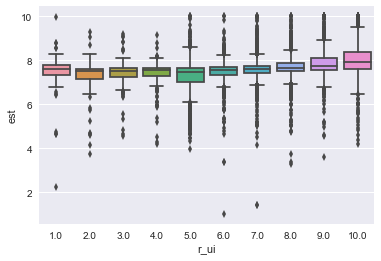

In [72]:
#Put the predictions into a dataframe and graph the predictions vs. the true rating. 
test_pred_df = pd.DataFrame(predictions)
test_pred_df.head(30)

details = pd.DataFrame(test_pred_df['details'].tolist())
test_pred_details = test_pred_df.join([details])

test_pred_details[test_pred_details['actual_k']>0].sort_values(['actual_k'], ascending=False)

#test_pred_details[test_pred_details['actual_k']>=0].plot(x='r_ui', y='est', kind = 'scatter')
sns.boxplot( x=test_pred_details['r_ui'], y=test_pred_details['est'])


In [30]:
#This code taken directly from Surprise Documentation 
#http://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user

from collections import defaultdict

def get_top_n(predictions, n):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=5)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings] )

(65537, ['0446608955'])
(98307, ['0061097861'])
(32773, ['0151003076', '0671641409', '0671041460', '0345409663'])
(163851, ['0822004437'])
(65549, ['0804110395'])
(262158, ['0440235596'])
(98322, ['0804113599'])
(262168, ['0316666343'])
(262169, ['055356983X', '0385729332'])
(131098, ['0380816849'])
(262171, ['2253076252'])
(32798, ['0440224705'])
(229409, ['0446607819', '0345391691'])
(32802, ['0804108587', '0440173701'])
(158385, ['0312312431'])
(65584, ['0671027387', '0553584480', '0767912241', '0451204379', '0440221471'])
(98356, ['0345351525'])
(131126, ['950491036X', '0060510323', '8401327865', '034539139X'])
(163901, ['006091565X'])
(92853, ['0553258478', '0140176314', '0091882109'])
(98371, ['0684859734'])
(229448, ['0385315287'])
(262219, ['0312265867'])
(98381, ['0061056901'])
(196621, ['0060194448'])
(131154, ['0446611867'])
(98391, ['0373790880', '0399151877', '0380819546', '0399148744', '0446612324'])
(196697, ['0385315147'])
(99, ['0671621009'])
(229478, ['159182317X', '1

(69042, ['0553284517'])
(240883, ['0879237902'])
(131657, ['0446605409'])
(265656, ['0425142868'])
(3514, ['0385336179'])
(69056, ['1880000938', '0898220416'])
(36299, ['0441004520', '0441067956', '0688159281', '0441007813'])
(69076, ['8433917269'])
(69078, ['0670887315', '0425179672', '0060987219', '0345300610', '0140283595'])
(167386, ['0380899434'])
(101851, ['0060652934', '0156001314', '0912528427', '1555601693', '0312619952'])
(134621, ['2253006165', '2226135022'])
(69089, ['3100767136'])
(3556, ['0842321969'])
(36327, ['0064400581', '0801096294', '0895770997', '0440466334'])
(167403, ['0340721995', '0099436116'])
(134636, ['0380804557'])
(137601, ['0380978202'])
(232945, ['0345370775', '0425133540', '0449006522', '0553582402', '0449002128'])
(101874, ['0553573209'])
(101876, ['0140714146'])
(134645, ['3453196015'])
(167418, ['0316611913'])
(232959, ['044990928X'])
(232964, ['0380725363', '0807023086', '0451183886', '0060916826'])
(39400, ['8401427568'])
(134663, ['0140620869'])
(

(240318, ['1551921987'])
(142017, ['0399143335'])
(43714, ['0140048324'])
(76483, ['0785283056', '0195060830'])
(76484, ['0312977433'])
(10949, ['0345378490'])
(174791, ['0141311037', '0689855540', '0689829337', '043912042X'])
(142024, ['0385058144'])
(240330, ['0316353299'])
(109265, ['0425161722'])
(43730, ['0684834723'])
(76499, ['1557041393', '0140043519', '0060528370', '0892550147', '0679756604'])
(142039, ['0380710722'])
(273113, ['0671870998', '0515124214', '0553801228', '0399144412', '0671737619'])
(109276, ['0446522252', '0449005615'])
(109278, ['0373706006'])
(165669, ['031286504X'])
(76512, ['0066214122'])
(273121, ['0812575482'])
(109287, ['0679746048'])
(105596, ['1568361467', '0312953615'])
(174830, ['0805019367', '0553261258'])
(76530, ['0060392452'])
(240375, ['0671822209'])
(11006, ['0451168690'])
(207616, ['0066211611', '0399150439'])
(207623, ['3442454492'])
(43785, ['0373484704'])
(240394, ['044021145X'])
(240401, ['0440439884', '0566036207'])
(240403, ['0142301019'

(117132, ['0399144900', '0399147926', '0385299281'])
(149907, ['0877733759', '0735201404', '0836237013'])
(149908, ['0330400967', '0553212478', '0002259877', '0140112103', '0060932813'])
(248221, ['0774806869', '0553802208', '0375726349'])
(117155, ['0440226430'])
(117162, ['0060938455'])
(149934, ['0316781142', '0786889004'])
(215473, ['0345439929'])
(248250, ['038075889X'])
(18879, ['0886779154'])
(248259, ['0399144463', '0449222217'])
(215492, ['0295983957'])
(248266, ['0439405572'])
(117196, ['0060922249'])
(84429, ['0440226430'])
(215512, ['0345339681', '0345320220'])
(117210, ['0765303418'])
(215523, ['0345424719'])
(51687, ['0312275420'])
(215529, ['0843948507', '0380760029'])
(117233, ['0446602612'])
(215548, ['0786902647'])
(84479, ['0439136350', '0439064864', '0671020250'])
(117251, ['0553251481', '0743242513', '0141002077', '0385318782'])
(150022, ['0684832283'])
(188847, ['0060987529'])
(51742, ['0394550846', '0385277970', '068480087X', '0375701966'])
(182819, ['156282841X'

(256402, ['0345348656'])
(223639, ['0192833723'])
(92571, ['8420672211'])
(223644, ['0671704656'])
(256413, ['0440127793'])
(141043, ['0618129022'])
(190900, ['0812505123'])
(158140, ['0316154075'])
(125381, ['0452282152'])
(190923, ['0446611913'])
(190925, ['0553578316', '0440220440', '0312958919', '1586190210', '0804109540'])
(113657, ['0140293248'])
(190937, ['0875962920'])
(125411, ['052594463X', '0880880252'])
(92648, ['0770426182'])
(92652, ['0440224489'])
(190960, ['0395977894'])
(256507, ['0553279556', '0316899984'])
(27140, ['0380790025', '0786205598'])
(92677, ['7561910908'])
(59912, ['0140187863'])
(184748, ['044922046X'])
(113752, ['0060537795', '1573220779'])
(158226, ['0060928514', '1563897407', '0765304015', '1401201172', '1401200095'])
(92696, ['0786885416'])
(59933, ['0140283641'])
(191007, ['0380798913'])
(27169, ['0505522799', '0451194691', '1551663023', '0373201524', '0373834977'])
(191014, ['0967044421'])
(125482, ['3423118210'])
(223787, ['0375504907', '0345452577

In [31]:
BR_Sample[BR_Sample['User-ID'] == 273113]

,User-ID,ISBN,Book-Rating,Implicit_Flag,Title,Author,Pub_Year,Publisher
251277,273113,0380470845,5,0,THE FULFILLMENT,LAVYRLE SPENCER,1979,Avon
636269,273113,0373218486,5,0,GOING HOME: UNFINISHED BUSINESS/ ISLAND OF FLO...,NORA ROBERTS,2002,Silhouette
1029502,273113,0440212057,5,0,THE COMPLETE RHYMING DICTIONARY,CLEMENT WOOD,1992,Laurel Editions
476785,273113,0515103969,5,0,THE ENDEARMENT,LAVYRLE SPENCER,1994,Jove Books
100939,273113,0515136379,5,0,KEY OF KNOWLEDGE (KEY TRILOGY (PAPERBACK)),NORA ROBERTS,2003,Jove Books
393806,273113,044661078X,5,0,PASSING THROUGH PARADISE,SUSAN WIGGS,2002,Warner Books
232757,273113,0515120006,5,0,HOLDING THE DREAM (DREAM TRILOGY),NORA ROBERTS,2001,Jove Books
543589,273113,0486277860,5,0,THE AWAKENING (DOVER THRIFT EDITIONS),KATE CHOPIN,1993,Dover Publications
121474,273113,0373484003,5,0,IRISH HEARTS,NORA ROBERTS,2000,Silhouette
130304,273113,051513287X,5,0,FACE THE FIRE (THREE SISTERS ISLAND TRILOGY),NORA ROBERTS,2002,Jove Books


In [32]:
data.raw_ratings
print 'Items: ' , trainset.n_items
print 'Users: ', trainset.n_users
print 'Ratings: ', trainset.n_ratings


Items:  48772
Users:  26757
Ratings:  80609


# Predictions for User/Book Pairs Not Found in Data
Lastly, the purpose of the recommender system is to predict a user's rating for books they have not yet rated.  
The following code identifies pairs of user and book that were not part of the original (training) dataset.  We then return the n books with the highest predicted rating for each user.

In [33]:
#This code taken directly from Surprise Source Code with slight modification to accomodate current processing power 
#https://github.com/NicolasHug/Surprise/blob/master/surprise/dataset.py

#Add in num_users (with default set to 1) to adjust for how many of the users you want to create 
# all user-book pairs (cartesian join) for prediction 
def build_anti_testset(self, fill=None, num_users=1):
        """Return a list of ratings that can be used as a testset in the
        :meth:`test() <surprise.prediction_algorithms.algo_base.AlgoBase.test>`
        method.
        The ratings are all the ratings that are **not** in the trainset, i.e.
        all the ratings :math:`r_{ui}` where the user :math:`u` is known, the
        item :math:`i` is known, but the rating :math:`r_{ui}`  is not in the
        trainset. As :math:`r_{ui}` is unknown, it is either replaced by the
        :code:`fill` value or assumed to be equal to the mean of all ratings
        :meth:`global_mean <surprise.dataset.Trainset.global_mean>`.
        Args:
            fill(float): The value to fill unknown ratings. If :code:`None` the
                global mean of all ratings :meth:`global_mean
                <surprise.dataset.Trainset.global_mean>` will be used.
        Returns:
            A list of tuples ``(uid, iid, fill)`` where ids are raw ids.
        """
        fill = self.global_mean if fill is None else float(fill)

        n=0
        anti_testset = []
        for u in self.all_users():
        # Add condition re: num_users to break process if number of users exceeds defined number  
            if n > num_users:
                break
            user_items = set([j for (j, _) in self.ur[u]])
            anti_testset += [(self.to_raw_uid(u), self.to_raw_iid(i), fill) for i in self.all_items() if i not in user_items]
        #Increment n by 1
            n +=1
        return anti_testset 


In [34]:
#Assign the train_data to be 'raw_ratings' again 
data.raw_ratings = train_data

#Use the build_anti_testset function above to create all books pairs for 10 users
#User rating is by default set to avg Book Rating
anti_testset = build_anti_testset(trainset, fill=None, num_users=15) 

#Get predictions for user/book pairs not found in training data
predictions = algo.test(anti_testset)

#Put predictios into dataframe
unknown_pred_df = pd.DataFrame(predictions)
unknown_pred_df.head()


,uid,iid,r_ui,est,details
0,54898,0553140841,7.629595,5.000000,"{u'actual_k': 0, u'was_impossible': False}"
1,54898,0446612529,7.629595,6.000000,"{u'actual_k': 0, u'was_impossible': False}"
2,54898,0679425888,7.629595,7.000000,"{u'actual_k': 0, u'was_impossible': False}"
3,54898,0380731851,7.629595,7.608696,"{u'actual_k': 0, u'was_impossible': False}"
4,54898,1585744646,7.629595,10.000000,"{u'actual_k': 0, u'was_impossible': False}"


In [35]:
#For each user, show the 20 books with the highest predicted rating

sort_pred = unknown_pred_df.groupby(['uid']).apply(lambda x: x.sort_values(['est'], ascending = False)).reset_index(drop=True)
top_five = sort_pred.groupby('uid').head(20)

In [36]:
#merge top_five and Books datasets to see Title/Author
top_five_books = pd.merge(top_five, Books, how='inner', left_on='iid', right_on='ISBN')
top_five_books.sort_values(['uid', 'est'])

#Flatten the details field to be 2 separate fields and merge with existing dataset
details = pd.DataFrame(top_five_books['details'].tolist())
top_details = top_five_books.join([details])

top_details.sort_values(['uid', 'est'], ascending=False)

,uid,iid,r_ui,est,details,ISBN,Title,Author,Pub_Year,Publisher,actual_k,was_impossible
2,253711,0395735270,7.629595,10.0,"{u'actual_k': 0, u'was_impossible': False}",0395735270,TASHA TUDOR'S HEIRLOOM CRAFTS,TOVAH MARTIN,1995,Houghton Mifflin Company,0,False
4,253711,2253010073,7.629595,10.0,"{u'actual_k': 0, u'was_impossible': False}",2253010073,THERESE RAQUIN,EMILE ZOLA,0,LP,0,False
6,253711,0062501178,7.629595,10.0,"{u'actual_k': 0, u'was_impossible': False}",0062501178,THE SON OF LAUGHTER : A NOVEL,FREDERICK BUECHNER,1994,HarperSanFrancisco,0,False
8,253711,8427285035,7.629595,10.0,"{u'actual_k': 0, u'was_impossible': False}",8427285035,ASESINATO EN EL CAMPO DE GOLF,AGATHA CHRISTIE,1997,AIMS International Books,0,False
11,253711,0801874254,7.629595,10.0,"{u'actual_k': 0, u'was_impossible': False}",0801874254,WHY SURVIVE?: BEING OLD IN AMERICA,"ROBERT N., MD BUTLER",2003,Johns Hopkins University Press,0,False
13,253711,157794254X,7.629595,10.0,"{u'actual_k': 0, u'was_impossible': False}",157794254X,PRAY FOR OUR NATION: SCRIPTURAL PRAYERS TO REV...,HARRISON HOUSE PUBLISHERS,2000,Harrison House,0,False
15,253711,0743251148,7.629595,10.0,"{u'actual_k': 0, u'was_impossible': False}",0743251148,"FOUND : THE BEST LOST, TOSSED, AND FORGOTTEN I...",DAVY ROTHBART,2004,Fireside,0,False
17,253711,0062508482,7.629595,10.0,"{u'actual_k': 0, u'was_impossible': False}",0062508482,EVERY PART OF THIS EARTH IS SACRED: NATIVE AME...,JANA STONE,1993,HarperCollins,0,False
19,253711,0385021747,7.629595,10.0,"{u'actual_k': 0, u'was_impossible': False}",0385021747,IN GOD WE TRUST: ALL OTHERS PAY CASH,JEAN SHEPHERD,1991,Main Street Books,0,False
21,253711,1561840564,7.629595,10.0,"{u'actual_k': 0, u'was_impossible': False}",1561840564,PROMETHEUS RISING,ROBERT ANTON WILSON,1992,New Falcon Publications,0,False


In [37]:
BR_Sample[BR_Sample['User-ID']==256873]

,User-ID,ISBN,Book-Rating,Implicit_Flag,Title,Author,Pub_Year,Publisher
545735,256873,0425184234,8,0,A SMALL DEATH IN LISBON,ROBERT WILSON,2002,Berkley Publishing Group
7774,256873,0316666343,10,0,THE LOVELY BONES: A NOVEL,ALICE SEBOLD,2002,"Little, Brown"
